# Bibliotecas

In [285]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Métricas de Erro

In [286]:
# Root Mean Square Error
def rmse_metric(img1, img2):
    return np.sqrt(np.mean((img1.astype("float") - img2.astype("float")) ** 2))

# Coleta das Imagens de Teste

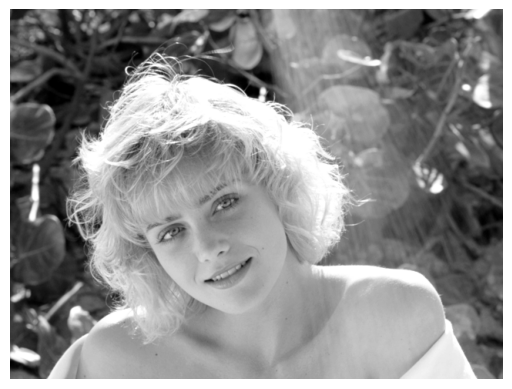

In [287]:
# Carregar a imagem em modo grayscale
imagem = cv2.imread('images\pgm_bin\marcie.pgm', cv2.IMREAD_GRAYSCALE)

# Exibindo imagem
plt.imshow(imagem, cmap='gray')
plt.axis('off') 
plt.show()

In [288]:
# Shape da Imagem
imagem.shape

(480, 640)

# Implementação JPEG 

## DCT

In [289]:
# Função que realiza a transformada DCT
def dct_transform(img, step=8):

    size = img.shape                    # Shape da imagem
    DCT = np.zeros(size, dtype=float)   # Cria uma matriz para armazenar os coeficientes DCT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            dct = cv2.dct(img[y:y+step, x:x+step])   # Aplica DCT no bloco 8x8

            DCT[y:y+step, x:x+step] = dct     # Salva o bloco DCT

    return DCT

# Função que realiza a inversa da DCT (IDCT)
def idct_transform(dct_coefs, step=8):

    size = dct_coefs.shape
    IDCT = np.zeros(size, dtype=float)  # Cria uma matriz para armazenar a imagem reconstruída

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            idct = cv2.idct(dct_coefs[y:y+step, x:x+step]) # Aplica IDCT 2D no bloco 8x8

            IDCT[y:y+step, x:x+step] = idct   # Salva o bloco reconstruído
    
    IDCT = IDCT + 128 # Desfaz o deslocamento de 128

    return IDCT

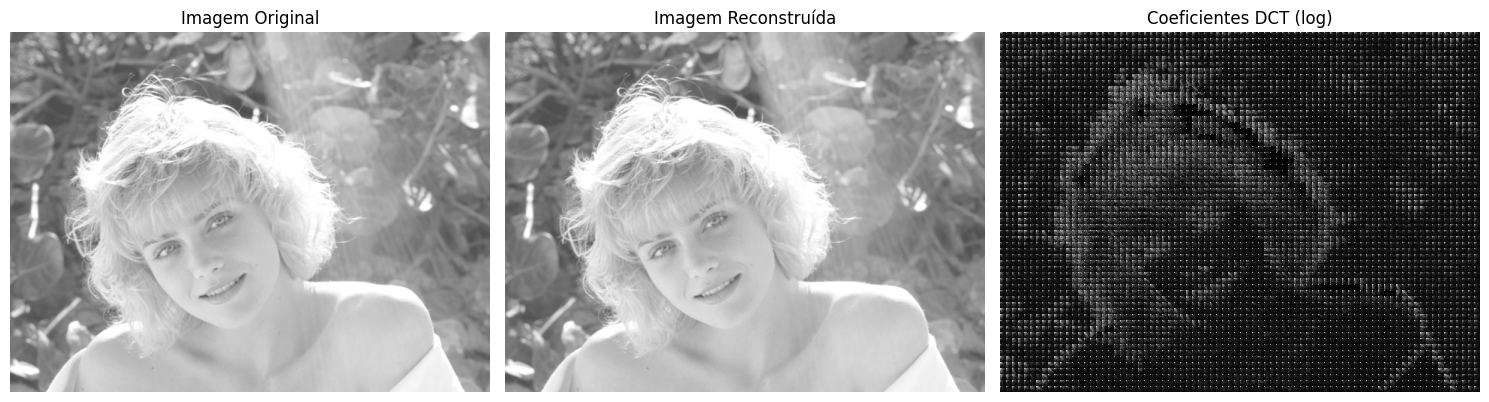

In [290]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza Transformada
DCT = dct_transform(img, step)

# Realiza a Transformada Inversa
IDCT = idct_transform(DCT, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

# Coeficientes DCT
plt.subplot(1, 3, 3)
plt.imshow(np.log(np.abs(DCT) + 1), cmap='gray')
plt.title('Coeficientes DCT (log)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [291]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 1.9735972688114828e-14
Métrica PSNR: 322.12845571680845 dB


## Fourier

In [292]:
def dft_transform(img, step=8):

    size = img.shape
    DFT_REAL = np.zeros(size, dtype=float)    # Matriz para armazenar coeficientes reais da DFT
    DFT_IM = np.zeros(size, dtype=float)      # Matriz para armazenar coeficientes imaginarios da DFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8
            
            # Aplica DFT 2D no bloco 8x8
            dft = cv2.dft(np.float32(img[y:y+step, x:x+step]), flags=cv2.DFT_COMPLEX_OUTPUT)

            DFT_REAL[y:y+step, x:x+step] = dft[:, :, 0]  # Salva o bloco DFT Real
            DFT_IM[y:y+step, x:x+step] = dft[:, :, 1]    # Salva o bloco DFT Imaginario

    # Magnitude da DFT
    dft_magnitude = cv2.magnitude(DFT_REAL, DFT_IM)

    return DFT_REAL, DFT_IM, dft_magnitude

def idft_transform(dft_coefs_real, dft_coefs_im, step=8):

    size = dft_coefs_real.shape
    IDFT_REAL = np.zeros(size, dtype=float)   # Matriz para armazenar coeficientes reais da IDFT
    IDFT_IM = np.zeros(size, dtype=float)     # Matriz para armazenar coeficientes imaginarios da IDFT

    for y in range(0, size[0], step):       # Percorre linhas de 8 em 8
        for x in range(0, size[1], step):   # Percorre colunas de 8 em 8

            dft = cv2.merge([dft_coefs_real[y:y+step, x:x+step], dft_coefs_im[y:y+step, x:x+step]])    # Junta os coefs reais e imaginários
            idft = cv2.idft(dft, flags=cv2.DFT_SCALE)                               # Aplica IDFT no bloco transformado

            IDFT_REAL[y:y+step, x:x+step] = idft[:, :, 0]     # Salva o bloco IDFT Real
            IDFT_IM[y:y+step, x:x+step] = idft[:, :, 1]     # Salva o bloco Imaginario
    
    # Magnitude da IDFT
    idft_magnitude = cv2.magnitude(IDFT_REAL, IDFT_IM)
    
    # Desfaz o deslocamento de 128
    IDFT_REAL = IDFT_REAL + 128

    return IDFT_REAL, IDFT_IM, idft_magnitude

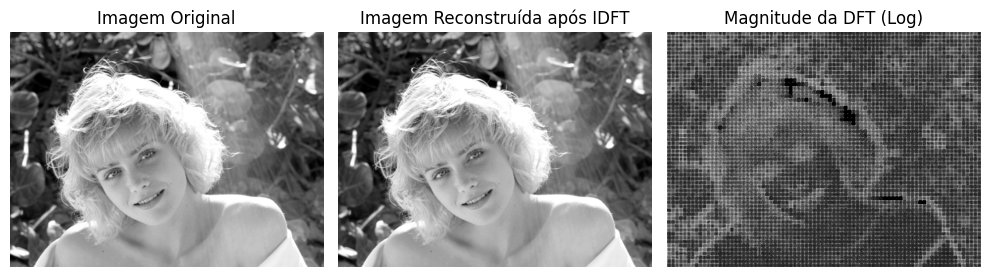

In [293]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Realiza a transformada DFT
DFT_REAL, DFT_IM, dft_magnitude = dft_transform(img, step)
log_magnitude = np.log(dft_magnitude + 1) # Aplicando log para melhorar a visualização

# Realiza a transformada inversa IDFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Desfaz o deslocamento de 128
img = img + 128

# Visualizar a imagem original e a reconstruída após a IDFT
plt.figure(figsize=(10, 7))

# Imagem original
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

# Magnitude da DFT
plt.subplot(1, 3, 3)
plt.imshow(log_magnitude, cmap='gray')
plt.title('Magnitude da DFT (Log)')
plt.axis('off')

# Imagem reconstruída após a IDFT
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray')
plt.title('Imagem Reconstruída após IDFT')
plt.axis('off')

plt.tight_layout()
plt.show()

In [294]:
# Métricas de Erro
rmse = rmse_metric(img, IDFT_REAL)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDFT_REAL)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 5.440281517250006e-07
Métrica PSNR: 173.41837613240259 dB


## Quantização DCT

In [295]:
def quantizacao_DCT(DCT, QM, step=8):
    
    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DCT.shape
    quant_coefs = np.zeros(size, dtype=float) # Matriz para armazenar os coeficientes quantizados
    dc_array = []                             # Array para armazenar os coeficientes DC originais
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            dct = DCT[y:y+step, x:x+step]

            DC = dct[0,0]            # Adquire o coeficiente DC
            dct = np.divide(dct, QM) # Divive a DCT pela matriz de quantização
            dct = dct.round()        # Arredondamento da matriz quantizada

            quant_coefs[y:y+step, x:x+step] = dct # Salva o bloco quantizado
            dc_array.append(DC)
    
    return quant_coefs, dc_array

def desquantization_DCT(quant_coefs, dc_array, QM, useDC=True, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = quant_coefs.shape
    original_coefs = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            # Multiplica a matriz quantizada pela matriz de quantização
            dct = np.multiply(quant_coefs[y:y+step, x:x+step], QM)

            if (useDC == True):
                dct[0,0] = dc_array[0]  # Recupera o coeficiente DC original
                dc_array = dc_array[1:] # Retira o primeiro elemento do array
        
            original_coefs[y:y+step, x:x+step] = dct
    
    return original_coefs

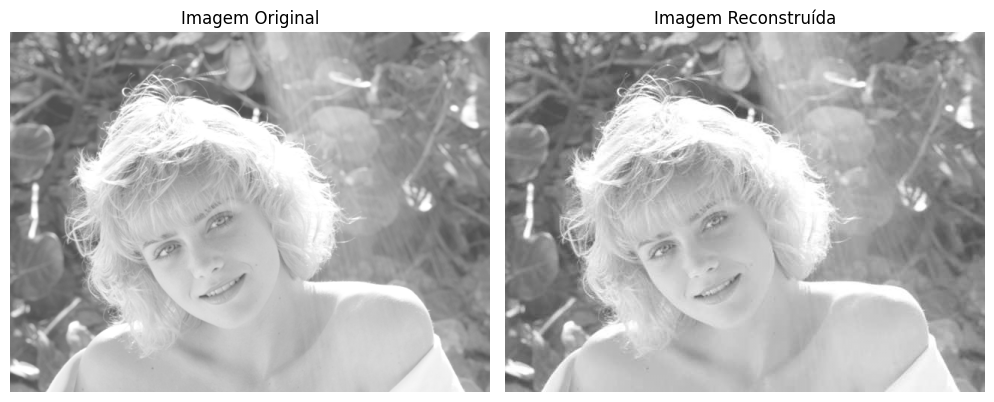

In [296]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DCT
DCT = dct_transform(img, step)

# Quantização
quant_coefs, dc_array = quantizacao_DCT(DCT, QM)

# Desquantização
original_coefs = desquantization_DCT(quant_coefs, dc_array, QM)

# Realiza a Transformada Inversa
IDCT = idct_transform(original_coefs, step)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDCT, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

In [297]:
# Métricas de Erro
rmse = rmse_metric(img, IDCT)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, IDCT)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.728205166809998
Métrica PSNR: 39.4132630671207 dB


## Quantização FOURIER

In [298]:
def quantizacao_DFT(DFT_REAL, DFT_IM, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = DFT_REAL.shape
    magnitude_quant = np.zeros(size, dtype=float)

    magnitude = cv2.magnitude(DFT_REAL, DFT_IM)
    phase = cv2.phase(DFT_REAL, DFT_IM)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Realizando quantização no bloco da matriz de magnitude
            magnitude_bloco = np.divide(magnitude[y:y+step, x:x+step], QM) # Divive pela matriz de quantização
            magnitude_bloco = magnitude_bloco.round()                      # Arredondamento da matriz quantizada

            magnitude_quant[y:y+step, x:x+step] = magnitude_bloco # Salva o bloco quantizado

    return magnitude_quant, phase

def desquantizacao_DFT(magnitude_quant, phase, QM, step=8):

    np.set_printoptions(precision=3)
    np.set_printoptions(suppress=True)
    
    size = magnitude_quant.shape
    original_dft_real = np.zeros(size, dtype=float)
    original_dft_im = np.zeros(size, dtype=float)

    for y in range(0,size[0],step):
        for x in range(0,size[1],step):

            # Multiplica a matriz quantizada pela matriz de quantização
            magnitude_bloco = np.multiply(magnitude_quant[y:y+step, x:x+step], QM)

            # Reconstrução da matriz de coeficientes reais
            real_bloco = magnitude_bloco * np.cos(phase[y:y+step, x:x+step])
            im_bloco = magnitude_bloco * np.sin(phase[y:y+step, x:x+step])

        
            original_dft_real[y:y+step, x:x+step] = real_bloco
            original_dft_im[y:y+step, x:x+step] = im_bloco

    return original_dft_real, original_dft_im

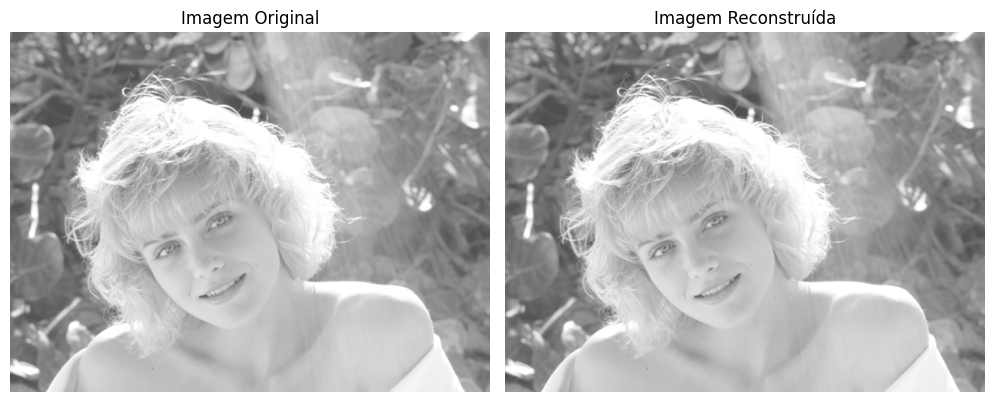

In [299]:
# Input
img = imagem.copy()
img = img.astype(float)             
img = img - 128                     # Centraliza os valores da imagem em torno de 0
step = 8                            # Define o tamanho do bloco (8x8)

# Matriz de Quantização
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

# Realiza Transformada DFT
IDFT_REAL, IDFT_IM, idft_magnitude = idft_transform(DFT_REAL, DFT_IM, step)

# Quantização
magnitude_quant, phase = quantizacao_DFT(DFT_REAL, DFT_IM, QM)

# Desquantização
original_coefs_real, original_coefs_im = desquantizacao_DFT(magnitude_quant, phase, QM)

# Realiza a Transformada Inversa
IDCT_REAL, IDFT_IM, magnitude = idft_transform(original_coefs_real, original_coefs_im)

# Desfaz o deslocamento de 128 da imagem
img = img + 128  

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Reconstruída
plt.subplot(1, 3, 2)
plt.imshow(IDFT_REAL, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Reconstruída')
plt.axis('off')

plt.tight_layout()
plt.show()

## Codificação Huffman

In [300]:
import heapq
from collections import defaultdict

class NoHuffman:
    def __init__(self, valor=None, freq=0, esq=None, dir=None):
        self.valor = valor
        self.freq = freq
        self.esq = esq
        self.dir = dir
    
    def __lt__(self, outro):  # Necessário para usar o heapq
        return self.freq < outro.freq

def construir_arb_huffman(frequencias):
    # Cria a heap com os nós folha
    heap = [NoHuffman(valor, freq) for valor, freq in frequencias.items()]
    heapq.heapify(heap)

    # Construa a árvore
    while len(heap) > 1:
        no1 = heapq.heappop(heap)
        no2 = heapq.heappop(heap)
        no_novo = NoHuffman(freq=no1.freq + no2.freq, esq=no1, dir=no2)
        heapq.heappush(heap, no_novo)

    return heap[0]  # Retorna a raiz da árvore

def gerar_codigos_huffman(raiz, prefixo="", codigos={}):
    if raiz is None:
        return
    if raiz.valor is not None:
        codigos[raiz.valor] = prefixo
    gerar_codigos_huffman(raiz.esq, prefixo + "0", codigos)
    gerar_codigos_huffman(raiz.dir, prefixo + "1", codigos)
    return codigos

from collections import Counter

# Função para aplicar a quantização e codificação de Huffman
def huffman_encode(quant_coefs):
    # Flatten a matriz para tratar os coeficientes DCT quantizados
    quant_flat = quant_coefs.flatten()
    
    # Contar a frequência dos coeficientes
    frequencias = Counter(quant_flat)

    # Construir a árvore de Huffman
    raiz = construir_arb_huffman(frequencias)
    
    # Gerar os códigos Huffman
    codigos_huffman = gerar_codigos_huffman(raiz)
    
    # Codificar a imagem (gerar a sequência binária)
    dados_codificados = ''.join([codigos_huffman[p] for p in quant_flat])
    
    return codigos_huffman, dados_codificados

def huffman_decode(dados_comprimidos):
    # Recupera os dados comprimidos e o dicionário de códigos Huffman
    dados_codificados = dados_comprimidos['dados_codificados']
    codigos_huffman = dados_comprimidos['codigos_huffman']
    
    # Inverter o dicionário de códigos Huffman para mapear os prefixos para os valores
    codigos_invertidos = {v: k for k, v in codigos_huffman.items()}
    
    # Variáveis para armazenar os coeficientes quantizados
    quant_coefs_rec = []
    i = 0  # Posição no stream de dados codificados
    
    # Descodificar os dados codificados
    while i < len(dados_codificados):
        # Tenta encontrar o código correspondente no stream de dados
        for tamanho in range(1, len(dados_codificados) - i + 1):
            prefixo = dados_codificados[i:i + tamanho]
            if prefixo in codigos_invertidos:
                # Adiciona o valor correspondente à lista de coeficientes
                quant_coefs_rec.append(codigos_invertidos[prefixo])
                i += tamanho  # Avança a posição no stream
                break
    
    # Converter a lista de coeficientes de volta para a forma matricial
    shape = dados_comprimidos['shape']
    quant_coefs_rec = np.array(quant_coefs_rec).reshape(shape)
    
    return quant_coefs_rec




## Funções de Compressão e Descompressão DCT

In [301]:
import pickle
import os

def dct_jpeg_compression(img, file_name, step=8):
    
    img = img.astype(float)             
    img = img - 128                     # Centraliza os valores da imagem em torno de 0

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # 1. Realiza Transformada DCT
    DCT = dct_transform(img)
    # 2. Quantização
    quant_coefs, dc_array = quantizacao_DCT(DCT, QM)
    # 3. Oredenação Zigue-Zague (Ainda tem que implementar)
    # 4. Codificação Huffman (Codificação por Entropia)
    codigos_huffman, dados_codificados = huffman_encode(quant_coefs)

    # Salvando dados comprimidos:
    dados_comprimidos = {
        'dados_codificados': dados_codificados,
        'codigos_huffman': codigos_huffman,
        'shape': quant_coefs.shape,
        'dc_array': dc_array
    }
    path = os.path.join('images/compressed', file_name)
    with open(path, 'wb') as f:
        pickle.dump(dados_comprimidos, f)
    print(f"Dados comprimidos salvos em {path}")

    # Desfaz o deslocamento de 128 da imagem
    img = img + 128


def dct_jpeg_descompression(img_path, step=8):

    # Matriz de Quantização
    QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                    [12, 12, 14, 19, 26, 58, 60, 55],
                    [14, 13, 16, 24, 40, 57, 69, 56],
                    [14, 17, 22, 29, 51, 87, 80, 62],
                    [18, 22, 37, 56, 68, 109, 103, 77],
                    [24, 35, 55, 64, 81, 104, 113, 92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103, 99]])

    # Carregar os dados comprimidos
    with open(img_path, 'rb') as f:
        dados_comprimidos = pickle.load(f)

    # Coeficientes quantizados e dc_array recuperados
    quant_coefs_rec = huffman_decode(dados_comprimidos)
    dc_array = dados_comprimidos['dc_array']

    # Desquantização
    original_coefs = desquantization_DCT(quant_coefs_rec, dc_array, QM)

    # Realiza a Transformada Inversa (IDCT)
    img_rec = idct_transform(original_coefs, step)

    return img_rec

In [302]:
# Compressão
img = imagem.copy()
img = img.astype(float)

file_name = 'imagem_comprimida_jpeg_dct.huff'
dct_jpeg_compression(img, file_name)

Dados comprimidos salvos em images/compressed\imagem_comprimida_jpeg_dct.huff


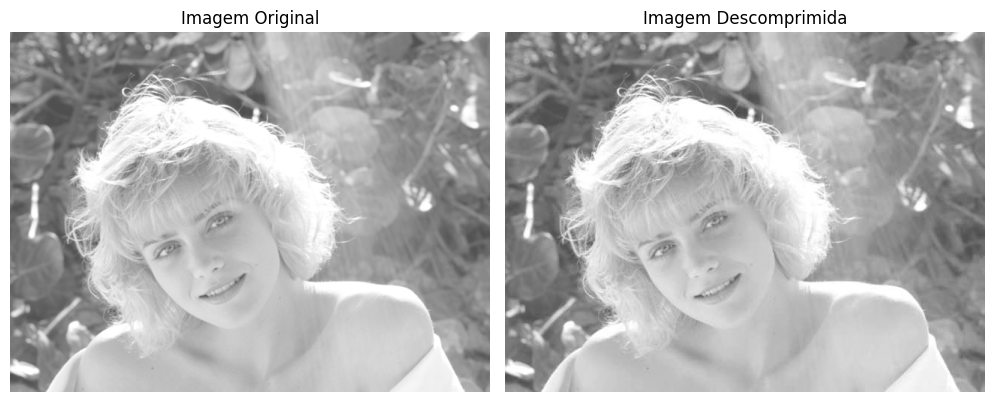

In [303]:
# Descompressão
img_path = 'images/compressed/imagem_comprimida_jpeg_dct.huff'
img_rec = dct_jpeg_descompression(img_path)

# Visualização
# Imagem Original
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Imagem Descomprimida
plt.subplot(1, 3, 2)
plt.imshow(img_rec, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Descomprimida')
plt.axis('off')

plt.tight_layout()
plt.show()

In [304]:
# Métricas de Erro
rmse = rmse_metric(img, img_rec)
print(f"Métrica RMSE: {rmse}")
psnr = cv2.PSNR(img, img_rec)
print(f"Métrica PSNR: {psnr} dB")

Métrica RMSE: 2.728205166809998
Métrica PSNR: 39.4132630671207 dB
